In [10]:
import cv2 as cv
from glob import glob
import os
import numpy as np
from utils.poincare import calculate_singularities
from utils.segmentation import create_segmented_and_variance_images
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils import orientation
from utils.crossing_number import calculate_minutiaes
from tqdm import tqdm
from utils.skeletonize import skeletonize

import matplotlib.pyplot as plt

%matplotlib inline

/mnt/sdb3/TEST/fingerprint_recognition/venv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def fingerprint_pipline(input_img):
    block_size = 16

    # pipe line picture re https://www.cse.iitk.ac.in/users/biometrics/pages/111.JPG
    # normalization -> orientation -> frequency -> mask -> filtering

    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(input_img.copy(), float(100), float(100))

    # color threshold
    # threshold_img = normalized_img
    # _, threshold_im = cv.threshold(normalized_img,127,255,cv.THRESH_OTSU)
    # cv.imshow('color_threshold', normalized_img); cv.waitKeyEx()

    # ROI and normalisation
    (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, block_size, 0.2)

    # orientations
    angles = orientation.calculate_angles(normalized_img, W=block_size, smoth=False)
    orientation_img = orientation.visualize_angles(segmented_img, mask, angles, W=block_size)
    
    # find the overall frequency of ridges in Wavelet Domain
    freq = ridge_freq(normim, mask, angles, block_size, kernel_size=5, minWaveLength=5, maxWaveLength=15)

    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq)

    # thinning oor skeletonize
    thin_image = skeletonize(gabor_img)

    # minutias
    minutias, end, bif = calculate_minutiaes(thin_image)

    # singularities
    singularities_img, FingerType = calculate_singularities(thin_image, angles, 1, block_size, mask)

    # visualize pipeline stage by stage
#     output_imgs = [input_img, normalized_img, segmented_img, orientation_img, gabor_img, thin_image, minutias, singularities_img]
    output_imgs = [input_img, minutias, singularities_img]
    
#     for i in range(len(output_imgs)): # Lặp qua từng ảnh output
#         if len(output_imgs[i].shape) == 2: # Nếu ảnh thứ i trong output là ảnh Gray(có 2 chiều)
#             output_imgs[i] = cv.cvtColor(output_imgs[i], cv.COLOR_GRAY2RGB) # Chuyển thành ảnh RGB để concatenate với 2 ảnh cuối
    
    # Chuyển list các ảnh thành ảnh 4x4
#     results = np.concatenate([np.concatenate(output_imgs[:4], 1), np.concatenate(output_imgs[4:], 1)]).astype(np.uint8)

#     return results
    return output_imgs, end, bif, FingerType

In [3]:
# open images
img_dir = './sample_inputs/*'
output_dir = './output/'
def open_images(directory):
    images_paths = glob(directory)
    images_names = [i.split('/')[-1][:-4] for i in images_paths]
    return images_names, np.array([cv.imread(img_path,0) for img_path in images_paths])

names, images = open_images(img_dir)
# image pipeline
os.makedirs(output_dir, exist_ok=True)

# for i, img in enumerate(tqdm(images)):
#     results = fingerprint_pipline(img)
    
# #     cv.imwrite(output_dir+str(i)+'.png', results)
# #     cv.imwrite(output_dir+names[i]+'.png', results)
#     cv.imshow('image pipeline', results); cv.waitKeyEx()
#     break
    
results, end, bif, fingertype = fingerprint_pipline(images[7])
for img in results:
    cv.imshow('image pipeline', img)
    cv.waitKeyEx()
    cv.destroyAllWindows()

# Preprocessing before Mathching

In [4]:
results1, end1, bif1, fingertype1 = fingerprint_pipline(images[0])
results2, end2, bif2, fingertype2 = fingerprint_pipline(images[1])

In [5]:
for img in results1:
    cv.imshow('image pipeline', img)
    cv.waitKeyEx()
    cv.destroyAllWindows()
    
for img in results2:
    cv.imshow('image pipeline', img)
    cv.waitKeyEx()
    cv.destroyAllWindows()

In [6]:
# ending points of fingerprint 1
x_end_1 = np.array(end1)[:, 1]
y_end_1 = np.array(end1)[:, 2]

In [7]:
# ending points of fingerprint 2
x_end_2 = np.array(end2)[:, 1]
y_end_2 = np.array(end2)[:, 2]

In [8]:
# bifucation points of fingerprint 1
x_bif_1 = np.array(bif1)[:, 1]
y_bif_1 = np.array(bif1)[:, 2]

In [9]:
# bifucation points of fingerprint 2
x_bif_2 = np.array(end2)[:, 1]
y_bif_2 = np.array(end2)[:, 2]

In [10]:
center_point1 = np.array(fingertype1)[:,1:].astype(int).mean(axis=0)
y1_center_point, x1_center_point = center_point1[0], center_point1[1]

center_point2 = np.array(fingertype2)[:,1:].astype(int).mean(axis=0)
y2_center_point, x2_center_point = center_point2[0], center_point2[1]

(1.6999999999999993, 294.3, -9.400000000000002, 571.4)

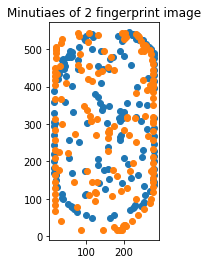

In [11]:
plt.scatter(x_end_1, y_end_1)
plt.scatter(x_end_2, y_end_2)
plt.title('Minutiaes of 2 fingerprint image')
plt.axis('scaled')

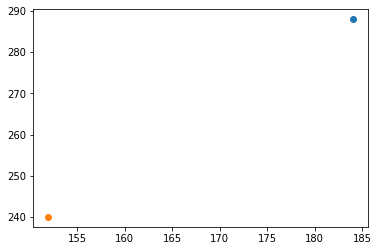

In [12]:
plt.scatter(x1_center_point, y1_center_point)
plt.scatter(x2_center_point, y2_center_point)

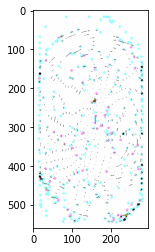

In [13]:
plt.imshow(results1[1] + results2[1])

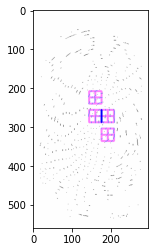

In [14]:
plt.imshow(results1[2] + results2[2])

In [15]:
x_translation = x2_center_point - x1_center_point
y_translation = y2_center_point - y1_center_point

In [16]:
# ending points of fingerprint 1
end_1 = np.array(end1)[:,1:]
end_2 = np.array(end2)[:,1:]

In [17]:
# bifucation points of fingerprint 1
bif_1 = np.array(bif1)[:,1:]
bif_2 = np.array(bif2)[:,1:]

In [18]:
translation_vecotr = np.array([x_translation, y_translation])

In [19]:
translation_vecotr

array([-32., -48.])

In [ ]:
new_end_1 = end_1 + translation_vecotr
new_bif_1 = bif_1 + translation_vecotr

(-31.8, 293.8, -25.05, 570.05)

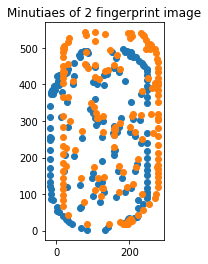

In [21]:
plt.scatter(new_end_1[:, 0], new_end_1[:, 1])
plt.scatter(end_2[:, 0], end_2[:, 1])
plt.title('Minutiaes of 2 fingerprint image')
plt.axis('scaled')

(-30.35, 285.35, 3.5, 564.5)

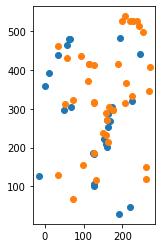

In [22]:
plt.scatter(new_bif_1[:, 0], new_bif_1[:, 1])
plt.scatter(bif_2[:, 0], bif_2[:, 1])
plt.axis('scaled')

In [23]:
"Center Point of finger1: ({}, {})".format(x1_center_point, y1_center_point)

'Center Point of finger1: (184.0, 288.0)'

In [24]:
"Center Point of finger2: ({}, {})".format(x2_center_point, y2_center_point)

'Center Point of finger2: (152.0, 240.0)'

In [25]:
"Center Point of finger1 moved: ({}, {})".format(x1_center_point + translation_vecotr[0], y1_center_point + translation_vecotr[1])

'Center Point of finger1 moved: (152.0, 240.0)'

# Matching

In [27]:
def DISTANCE(U, V) -> float:
    """
    """
    return np.sqrt((U[0] - V[0])**2 + (U[1] - V[1])**2)

In [28]:
def Points_distance(points1, points2) -> list:
    n = points1.shape[0]
    m = points2.shape[0]
    Distance = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            Distance[i, j] = DISTANCE(points1[i], points2[j])
    return Distance

In [57]:
def Filter_Points(ListPoints, CenterPoint, size = (0,0)):
    """
    """
    n = ListPoints.shape[0]
    ResultPoints = []
    for i in range(n):
        distance = np.abs(CenterPoint - ListPoints[i])
        if (distance[0] <= size[0]/2) and (distance[1] <= size[1]/2):
            ResultPoints.append(ListPoints[i].tolist())
    return np.array(ResultPoints)

In [67]:
def Transtation_Finger(Minutiae, Trans_Vector) -> np.ndarray:
    """
    """
    return Minutiae + Trans_Vector

In [99]:
def MATCH(img_finger1, img_finger2, alpha=0.5, box_size=(0, 0)) -> bool:
    """
    """
    # Get minutiae and centerpoint
    imgresult1, end1, bif1, fingertype1 = fingerprint_pipline(img_finger1)
    imgresult2, end2, bif2, fingertype2 = fingerprint_pipline(img_finger2)
    
    # Get CenterPoint
    center_point1 = np.array(fingertype1)[:,1:].astype(int).mean(axis=0)
    y1_center_point, x1_center_point = center_point1[0], center_point1[1]

    center_point2 = np.array(fingertype2)[:,1:].astype(int).mean(axis=0)
    y2_center_point, x2_center_point = center_point2[0], center_point2[1]
    
    centerpoint = np.array([x2_center_point, y2_center_point])
 
    # Calculate Translation Vector
    x_translation = x2_center_point - x1_center_point
    y_translation = y2_center_point - y1_center_point
    translation_vecotr = np.array([x_translation, y_translation])
    
    # ending points of fingerprint 1
    end_1 = np.array(end1)[:,1:]
    end_2 = np.array(end2)[:,1:]
    
    # bifucation points of fingerprint 1
    bif_1 = np.array(bif1)[:,1:]
    bif_2 = np.array(bif2)[:,1:]
    
    # Translation minutiaes
    end_1 = Transtation_Finger(end_1, translation_vecotr)
    bif_1 = Transtation_Finger(bif_1, translation_vecotr)
    
    # Filter minutiaes
    new_end_1 = Filter_Points(end_1, centerpoint, size=box_size)
    new_bif_1 = Filter_Points(bif_1, centerpoint, size=box_size)
    new_end_2 = Filter_Points(end_2, centerpoint, size=box_size)
    new_bif_2 = Filter_Points(bif_2, centerpoint, size=box_size)
    
    n1_end = new_end_1.shape[0]
    n1_bif = new_bif_1.shape[0]
    n2_end = new_end_2.shape[0]
    n2_bif = new_bif_2.shape[0]
    
    # Match ending points
    Distance_end = Points_distance(new_end_1, new_end_2)
    end_min_dist = Distance_end.min(axis=0)
    end_min_index = Distance_end.argmin(axis=0)
    
    # Match bifucation points
    Distance_bif = Points_distance(new_bif_1, new_bif_2)
    bif_min_dist = Distance_bif.min(axis=0)
    bif_min_index = Distance_bif.argmin(axis=0)
    
    # Check Matching
    end_matched = np.where(end_min_dist <= 15)[0].shape[0]
    bif_matched = np.where(bif_min_dist <= 15)[0].shape[0]
    
    if (end_matched + bif_matched)/(n1_end + n1_bif) >= alpha:
        return True
    else:
        return False

In [59]:
box_size = (150, 300)

In [98]:
MATCH(images[0], images[7], box_size=(150, 300))

False

In [100]:
def Draw_Result():
    """
    """
    pass

In [13]:
import random
from itertools import chain
# random.seed(9)

class MAS:
    # Attributes
    __A = []
    __B = []
    __Code = {}
    __X = {}
    __S = 0b0 # Mask bit string
    __k = 0 # unambiguous degree of Language set
    __m = 0 # bit length of S
    __word_bit = 0 # bit length of code element
    __Padding_word = '' # word for pading
    
    # Constructor
    def __init__(self, A, B, Code, X, S, k, PaddingWord):
        self.__A = A
        self.__B = B
        self.__Code = Code
        self.__X = X
        self.__S = S
        self.__k = k 
        self.__m = len(self.__S) 
        self.__word_bit = len(list(self.__Code.values())[0])
        self.__Padding_word = self.__B.index(PaddingWord)
        print("MAS cryptosystem initialization successful!")
        print("Author: Thanh HoangVan")
        print("Github: thanhhoangvan")
        print("+-----------------------------------------+")
    
    # Methods
    def __Msg2Index(self, Msg, Dictionary) -> list:
        """
        Convert index of word to message by dictionary list
        ---
        Parameters:
        - Dictionary: List of all word
        - Msg: Message
        ---
        Return:
        - List of index word in message
        ---
        Example
        - Dictionary: ['c', 'a1', 'a2', 'a3', 'b1', 'b2', 'b3', 'b4']
        - Message: "a1a2a3b1"
        - Return: [1, 2, 3, 4]
        """
        if len(Msg) == 0:
            raise Exception("Message is empty!")
        for i in Dictionary:
            Msg = Msg.replace(i, str(Dictionary.index(i)))
        return [int(i) for i in Msg]

    def __Index2Msg(self, WordIndex, Dictionary) -> str:
        """
        Convert index of word to message by dictionary list
        ---
        Parameters:
        - WordIndex: List of index word
        - Dictionary: List of all word
        ---
        Return:
        - Message string
        ---
        Example
        - Dictionary: ['c', 'a1', 'a2', 'a3', 'b1', 'b2', 'b3', 'b4']
        - WordIndex: [1, 2, 3, 4]
        - Return: "a1a2a3b1"
        """
        Msg = ""
        for i in WordIndex:
            Msg = Msg + Dictionary[i]
        return Msg
    
    def __PlainText2Index(self, Msg='') -> list:
        """
        Split the words in the Message into a list of index this word in A
        ---
        Parameter:
        - Msg: a message(string)
        ---
        Retrun:
        - List of words
        ---
        Example:
        >>> A = ['u1', 'u2', 'u3']
        >>> __Msg2Index("u1u3u2u3") -> [0, 2, 1, 2]
        """
        if len(Msg) == 0:
            raise Exception("Message is empty!")
        for i in self.__A:
            Msg = Msg.replace(i, str(self.__A.index(i)))
        return [int(i) for i in Msg]

    def __EncodedMsg2Index(self, EMsg='') -> list:
        """
        """
        if len(msg) == 0:
            raise Exception("Encoded message is empty!")
        for i in self.__B:
            EMsg = EMsg.replace(i, str(self.__B.index(i)))
        return [int(i) for i in EMsg] # split index number to list    

    def __EncodedMsg2Binary(self, EMsg='') -> bytes:
        """
        Convert encoded message to binary result
        ---
        Parameter:
        - EMsg: String of encoded message(String)
        ---
        Result:
        - bytes string of result
        ---
        Example
        - Encoded message: 'ca1b1a2'
        with {'c': b'110', 'a1':b'001', 'a2':b'010', 'b1':b'100'}
        - Result: b'110001100010'
        """
        BinaryResult = b''
        if len(msg) == 0:
            raise Exception("Encoded message is empty!")
        word_index = self.__EncodedMsg2Index(EMsg)
        EMsg = [self.__B[i] for i in word_index] # split index number to list
        for i in EMsg:
            temp = self.__Code[i]
            BinaryResult = BinaryResult + temp
        return BinaryResult

    def __NormalizeLanguage(self) -> list:
        """
        Convet all word in X to list of index word
        ---
        Example
        ---
        -  X1 = {'c'}
        -  X2 = {'ca1', 'a1b1'}
        -  X3 = {'b1a2', 'ca1a3b1'}
        -  X4 = {'a2b2'}
        -  X5 = {'b2a3', 'a3'}
        -  X = [X1, X2, X3, X4, X5]
        => Result: X = [[[0]], [[0, 1], [1, 4]], [[0, 1, 3, 4], [4, 2]], [[2, 5]], [[3], [5, 3]]]
        """
        Normlized = []
        for i in self.__X:
            temp = []
            for word in i:
                temp.append(self.__Msg2Index(word, self.__B))
            Normlized.append(temp)
        return Normlized

    def __PADDING(self, EMsg) -> list:
        """
        Hàm đệm bit vào chuỗi
        """
        while len(EMsg)*self.__word_bit < self.__m:
            EMsg.append(self.__Padding_word)
        return EMsg
    
    def __UNPADDING(self, EMsg) -> list:
        """
        """
        while self.__Padding_word in EMsg:
            EMsg.remove(self.__Padding_word)
        return EMsg

    def __EXTRACT(self, Encoded_Word) -> list:
        """
        The function parses a list of letters and splits them into words
        ---
        Parameter:
        - Encoded_Word: List of all word in  Encoded Message
        ---
        Result:
        - List of corresponding plaintext words
        ---
        Example:
        ---
        - Encoded_Word
        [[0, 0, 1, 3, 4, 3], 
         [4, 2, 2, 5, 5, 3], 
         [0, 1, 0, 7, 7, 7], 
         [4, 2, 5, 3, 7, 7]]
        - Result:
        [[0], [0, 1, 3, 4], [3]]
         [[4, 2], [2, 5], [5, 3]]
         [[0, 1], [0]]
         [[4, 2], [5, 3]]
        """
        Language = list(chain.from_iterable(self.__NormalizeLanguage())) # List of all word in language [[0], [0, 1], [1, 4], [0, 1, 3, 4], [4, 2], [2, 5], [5, 3], [3]] 
        TMP = []
        Solution = []
        W = []

        def FIND(msg, len_msg, k):
            nonlocal W, TMP, Solution
            for i in Language:
                if len(W) + len(i) <= len_msg:
                    W = W + i
                    Solution = Solution + [i]
                else:
                    continue
                if (len(W) == len_msg) and (W == msg):
                    TMP = TMP + [list(Solution)]
                else:
                    FIND(msg, len_msg, k+1)
                W = W[:-len(i)]
                Solution.pop()
        
        for i in Encoded_Word:
            ListChars = self.__UNPADDING(i)
            n = len(ListChars)
            W = []
            Solution = []
            FIND(i, n, 1)

        return TMP
        
    def __MASKING(self) -> bytes:
        """
        Hàm thêm lớp mặt nạ vào bit string đầu ra
        """
        pass
    
    def __e_g(self, k, Language) -> int:
        """
        Encode function
        ---
        Parameter:
        - k: index of Language
        - Language: List of Language
        ---
        Return
        ---
        - A random element corresponding to the index k
        """
        return random.choice(Language[k]) 
    
    def __d_g(self) -> list:
        """
        """
        pass
    
    def Encode(self, Msg="") -> bytes:
        """
        Encryption function
        ---
        
        Parameters
        ---
        - Msg: Messages to be encrypted
        
        Return
        ---
        - BitResult: The binary code of the encrypted message
        
        Example
        ---
        """
        
        # Check null message exception
        if len(Msg) == 0:
            raise Exception("Input message is empty!")
        
        Language = self.__NormalizeLanguage() # [[[0]], [[1, 4], [0, 1]], [[0, 1, 3, 4], [4, 2]], [[2, 5]], [[3], [5, 3]]]
        wordIndex = self.__PlainText2Index(Msg) # [0, 2, 4, 2, 3, 4, 1, 0, 2, 4]

        # initialization
        W = [] # list of all encode word in encoded msg
        i, j = 0, 0 # i_current msg word, j_current block bit of encode word(encoded msg)
        n = len(wordIndex) # number of word in message

        # main cryptosystem
        while True:
            #============================================================
            if (i >= n):
                break # break first while loop

            count = 0
            temp = [] # Current encoded word
            while True:

                if (count >= self.__k) or (len(temp)*self.__word_bit == self.__m): # Kiểm tra điều kiện độ dài từ W_j < m
                    if len(temp)*self.__word_bit < self.__m:
                        temp = self.__PADDING(temp)
                    
                    # Masking
                    # if j == 1:
                    #     pass
                    # else:
                    #     pass
                    
                    W.append(temp)
                    j = j + 1
                    break

                #============================================================
                try:
                    newEncodedWord = self.__e_g(wordIndex[i], Language)
                    if len(temp + newEncodedWord)*self.__word_bit <= self.__m:
                        temp = temp + newEncodedWord
                        count = count + 1
                        i = i + 1
                    else:
                        temp = self.__PADDING(temp) 
                except:
                    if len(temp)*self.__word_bit < self.__m:
                        temp = self.__PADDING(temp)
                    
                    # Masking
                    # if j == 1:
                    #     pass
                    # else:
                    #     pass
                    
                    W.append(temp)
                    print('-'*20)
                    j = j + 1
                    break
                    
                # if len(temp + newEncodedWord)*self.__word_bit <= self.__m:
                #     temp = temp + newEncodedWord
                #     count = count + 1
                #     i = i + 1
                # else:
                #     temp = self.__PADDING(temp) 

                #============================================================

                print(count, self.__k)
                print(temp, '\n')
            print('='*20)

        return W
    
    def Decode(self, EMsg=[]) -> str:
        """
        Decryption function
        ---
        Parameters
        ---
        Return
        ---
        Example
        ---
        """
        # Check null message exception
        if len(EMsg) == 0:
            raise Exception("Input message is empty!")
        
        Msg = []
        i, j = 0, 0
        n_word = len(EMsg)  # number of word in encoded message

        while True:
            
            # Unmasking
            if j == 0:
                # unmasking
                pass
            else:
                # unmasking
                pass
            
            tmp = self.__EXTRACT(EMsg)
            return tmp
        
        

if __name__ == '__main__':
    # Example Initialization
    A = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    B = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n','o', 'p']
    Code = {'a': b'1000',
            'b':b'1110',
            'c':b'0011', 
            'd':b'1111', 
            'e':b'1101', 
            'f':b'0010', 
            'g':b'1100', 
            'h':b'0101',
            'i':b'1011',
            'j':b'0000',
            'k':b'1001',
            'l':b'0111',
            'm':b'0100',
            'n':b'1010',
            'o':b'0001',
            'p':b'0110'}
    
    # Language
    X0 = {'abc', 'lco'}
    X1 = {'jkl', 'cb', 'defg'}
    X2 = {'cad', 'aohk'}
    X3 = {'efg', 'gimj'}
    X4 = {'hgf', 'ad'}
    X5 = {'kjo', 'dgj'}
    X6 = {'ged'}
    X7 = {'ome', 'nko'}
    X8 = {'acb', 'hkm'}
    X9 = {'mok'}
    X = [X0, X1, X2, X3, X4, X5, X6, X7, X8, X9]
    paddingWord = 'p'
    k = 3
    
    # Message
    msg = '123456789'
    emsg = [[3, 4, 5, 6, 2, 0, 3, 6, 8, 1, 2, 9], [0, 3, 3, 6, 9, 6, 4, 3, 15, 15, 15, 15], [1, 3, 1, 0, 1, 4, 7, 1, 0, 1, 2, 15], [1, 2, 1, 4, 1, 0, 15, 15, 15, 15, 15, 15]]
    
    # Mask
    S = b'101000110110101010001101101000110110101010001101'

    #=======================================
    Cryptosystem = MAS(A, B, Code, X, S, k, paddingWord)
#     print(Cryptosystem.Encode(msg))
    msg = Cryptosystem.Decode(emsg)

MAS cryptosystem initialization successful!
Author: Thanh HoangVan
Github: thanhhoangvan
+-----------------------------------------+


In [14]:
for i in msg:
    print(i)

[[3, 4, 5, 6], [2, 0, 3], [6, 8, 1, 2, 9]]
[[0, 3], [3, 6, 9], [6, 4, 3]]
[[1, 3, 1, 0, 1, 4], [7, 1, 0, 1, 2]]
[[1, 2, 1, 4, 1, 0]]


In [15]:
np.array([[3, 4, 5, 6, 2, 0, 3, 6, 8, 1, 2, 9], [0, 3, 3, 6, 9, 6, 4, 3, 15, 15, 15, 15], [1, 3, 1, 0, 1, 4, 7, 1, 0, 1, 2, 15], [1, 2, 1, 4, 1, 0, 15, 15, 15, 15, 15, 15]])

array([[ 3,  4,  5,  6,  2,  0,  3,  6,  8,  1,  2,  9],
       [ 0,  3,  3,  6,  9,  6,  4,  3, 15, 15, 15, 15],
       [ 1,  3,  1,  0,  1,  4,  7,  1,  0,  1,  2, 15],
       [ 1,  2,  1,  4,  1,  0, 15, 15, 15, 15, 15, 15]])